# Coursework final

- Andy Yuan
- Aidan Dignam
- Amelia Walker
- Owen Stevenson


# Question 1

In [2]:
# Imports

import numpy as np
import polars as pl
import pandas as pd

# Clustering
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering, MiniBatchKMeans

# Dimensionality reduction
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.manifold import TSNE

# Tree-based models
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor

# Model selection and evaluation
from sklearn.model_selection import (
    GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, 
    cross_validate, RepeatedKFold
)

from sklearn.metrics import (
    silhouette_samples, silhouette_score, confusion_matrix, 
    roc_curve, roc_auc_score, classification_report, accuracy_score, r2_score
)

# Preprocessing and feature selection
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector

# Linear models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import linear_model

# XGBoost
from xgboost import XGBRegressor, XGBClassifier

# Shap
import shap
shap.initjs() # Import Java engine.

# Plotting
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Statistical and optimization tools
from scipy.sparse import csr_matrix
from scipy.stats import zscore
from scipy.special import factorial
import scipy.optimize as so

# Text processing
import sklearn.feature_extraction.text as sktext
import re

# Dimensionality reduction
import umap

# Miscellaneous
import os
from itertools import chain, combinations
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
import heapq


C:\Users\Andy Yuan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
householdspend = pl.read_csv("../Coursework Data/HouseholdSpend.csv")
demographics = pl.read_csv("../Coursework Data/DemoStats.csv")

In [4]:
# Combine data on the CODE variable
data_combined = householdspend.join(demographics, on="CODE", how="full")

# Dropping columns described in the Discord announcements
columns_to_drop = ["HSHNIAGG", "HSAGDISPIN", "HSAGDISCIN", 
                   "HSEP001", "HSEP002", "HSEP003", "HSEP004", "HSEP005", "HSEP006", "HSEP007", 
                   "CODE", "CODE_right", "GEO", "GEO_right"]
ifexisting_cols = [col for col in columns_to_drop if col in data_combined.columns]
datahouseholds = data_combined.drop(ifexisting_cols)
datahouseholds.describe()

statistic,HSBASHHD,HSTT001,HSTE001,HSTX001,HSTC001,HSSH001S,HSFD001S,HSHO001S,HSHC001S,HSHF001S,HSTR001S,HSRE001S,HSPC001S,HSCL001S,HSED002S,HSRO001S,HSTA001S,HSGC001S,HSME001S,HSEP001S,HSMG001S,HSTE001ZBS,HSWH002S,HSWH028S,HSWH040S,HSWH041S,HSWH042S,HSSH001,HSSH002,HSSH003,HSSH004,HSSH053,HSSH054,HSSH005,HSSH006,HSSH007,…,ECYRIMINDI,ECYRIMNEPA,ECYRIMPAKI,ECYRIMSRI,ECYRIMSASO,ECYRIMOCE,ECYRIMAUSS,ECYRIMOCEO,ECYPIMHPOP,ECYPIMNI,ECYPIMIM,ECYPIMP01,ECYPIM0110,ECYPIM1115,ECYPIM1621,ECYPIM22CY,ECYPIMNPER,ECYAIMHPOP,ECYAIMNI,ECYAIMIM,ECYAIM_0_5,ECYAIM_514,ECYAIM1524,ECYAIM2544,ECYAIM45P,ECYAIMNPER,ECYGENHPOP,ECYGEN1GEN,ECYGEN2GEN,ECYGEN3GEN,ECYTCAHPOP,ECYTCACIT,ECYTCA_U18,ECYTCA_18P,ECYNCANCIT,ECYNCA_U18,ECYNCA_18P
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,…,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",18.432629,2.4008e6,2.1917e6,421335.834661,1.6065e6,388812.651163,278016.994627,111401.557243,109343.827301,76103.411113,271135.371662,87929.804561,45315.650319,70798.452452,34398.504565,3570.867859,70468.350013,25849.158365,33310.372386,115213.19111,48732.91062,209040.481816,67544.21004,4806.924846,112565.256385,15089.24985,9034.840695,388812.651163,303764.492909,89251.190609,88053.450315,87440.075786,613.374529,183.700577,828.596641,185.443075,…,0.477122,0.005692,0.038764,0.008754,0.00028,0.007272,0.005106,0.002166,45.881762,31.717238,11.757474,4.721479,2.368195,1.391643,1.640656,1.635501,2.407051,45.881762,31.717238,11.757474,1.066154,2.036562,2.230265,5.299374,1.125119,2.407051,45.881762,14.168175,7.448384,24.265204,45.881762,40.528679,7.761493,32.767185,5.353084,0.85628,4.496803
"""std""",69.379951,9.1329e6,8.0562e6,1.5969e6,5.9255e6,1.3661e6,1.0471e6,420881.63654,429642.774397,290959.592849,1.0751e6,327376.60947,163377.943862,249311.269506,114999.916794,14386.745375,264786.580294,94955.831503,127397.296924,431645.982804,206454.726959,1.2713e6,341440.420828,40531.631801,898861.389623,51492.602769,35858.838458,1.3661e6,1.0270e6,292325.224526,287942.333453,285952.018412,2371.573942,993.000184,3140.51177,1269.469849,…,2.516032,0.123928,0.364373,0.142995,0.02439,0.118581,0.094428,0.057987,171.817976,149.721097,32.868441,14.28478,7.28958,4.605282,5.813031,5.761745,10.479555,171.817976,149.721097,32.868441,3.400699,6.112712,6.550715,14.905824,3.936661,10.479555,171.817976,40.185434,24.588753,131.818196,171.817976,163.866165,34.782061,130.449848,17.893635,3.211073,15.020402
"""min""",0.0,-24249.492537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4599e7,0.0,0.0,-1.6806e7,-26676.98553,-204380.698719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",3.0,288995.986572,265546.050861,3315

In [6]:
# identify which columns are strings
string_columns = datahouseholds.select(pl.col(pl.Utf8())).columns

# Replace NA with median values of the columns converted to string
for col in string_columns:
    median = (
        datahouseholds[col].replace("NA", None)
        .cast(pl.Float64)
        .median()
    )
    datahouseholds = datahouseholds.with_columns(
        pl.col(col).replace("NA", None)
        .cast(pl.Float64)
        .fill_null(median)
        .alias(col)
    )

In [ ]:
# recast for good measure
string_columns = datahouseholds.select(pl.col(pl.Utf8())).columns
datahouseholds_cleaned = datahouseholds.with_columns(
    pl.col(string_columns).cast(pl.Float64)
)
datahouseholds_cleaned.describe()

statistic,HSBASHHD,HSTT001,HSTE001,HSTX001,HSTC001,HSSH001S,HSFD001S,HSHO001S,HSHC001S,HSHF001S,HSTR001S,HSRE001S,HSPC001S,HSCL001S,HSED002S,HSRO001S,HSTA001S,HSGC001S,HSME001S,HSEP001S,HSMG001S,HSTE001ZBS,HSWH002S,HSWH028S,HSWH040S,HSWH041S,HSWH042S,HSSH001,HSSH002,HSSH003,HSSH004,HSSH053,HSSH054,HSSH005,HSSH006,HSSH007,…,ECYRIMINDI,ECYRIMNEPA,ECYRIMPAKI,ECYRIMSRI,ECYRIMSASO,ECYRIMOCE,ECYRIMAUSS,ECYRIMOCEO,ECYPIMHPOP,ECYPIMNI,ECYPIMIM,ECYPIMP01,ECYPIM0110,ECYPIM1115,ECYPIM1621,ECYPIM22CY,ECYPIMNPER,ECYAIMHPOP,ECYAIMNI,ECYAIMIM,ECYAIM_0_5,ECYAIM_514,ECYAIM1524,ECYAIM2544,ECYAIM45P,ECYAIMNPER,ECYGENHPOP,ECYGEN1GEN,ECYGEN2GEN,ECYGEN3GEN,ECYTCAHPOP,ECYTCACIT,ECYTCA_U18,ECYTCA_18P,ECYNCANCIT,ECYNCA_U18,ECYNCA_18P
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,…,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",18.432629,2.4008e6,2.1917e6,421335.834661,1.6065e6,388812.651163,278016.994627,111401.557243,109343.827301,76103.411113,271135.371662,87929.804561,45315.650319,70798.452452,34398.504565,3570.867859,70468.350013,25849.158365,33310.372386,115213.19111,48732.91062,209040.481816,67544.21004,4806.924846,112565.256385,15089.24985,9034.840695,388812.651163,303764.492909,89251.190609,88053.450315,87440.075786,613.374529,183.700577,828.596641,185.443075,…,0.477122,0.005692,0.038764,0.008754,0.00028,0.007272,0.005106,0.002166,45.881762,31.717238,11.757474,4.721479,2.368195,1.391643,1.640656,1.635501,2.407051,45.881762,31.717238,11.757474,1.066154,2.036562,2.230265,5.299374,1.125119,2.407051,45.881762,14.168175,7.448384,24.265204,45.881762,40.528679,7.761493,32.767185,5.353084,0.85628,4.496803
"""std""",69.379951,9.1329e6,8.0562e6,1.5969e6,5.9255e6,1.3661e6,1.0471e6,420881.63654,429642.774397,290959.592849,1.0751e6,327376.60947,163377.943862,249311.269506,114999.916794,14386.745375,264786.580294,94955.831503,127397.296924,431645.982804,206454.726959,1.2713e6,341440.420828,40531.631801,898861.389623,51492.602769,35858.838458,1.3661e6,1.0270e6,292325.224526,287942.333453,285952.018412,2371.573942,993.000184,3140.51177,1269.469849,…,2.516032,0.123928,0.364373,0.142995,0.02439,0.118581,0.094428,0.057987,171.817976,149.721097,32.868441,14.28478,7.28958,4.605282,5.813031,5.761745,10.479555,171.817976,149.721097,32.868441,3.400699,6.112712,6.550715,14.905824,3.936661,10.479555,171.817976,40.185434,24.588753,131.818196,171.817976,163.866165,34.782061,130.449848,17.893635,3.211073,15.020402
"""min""",0.0,-24249.492537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4599e7,0.0,0.0,-1.6806e7,-26676.98553,-204380.698719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",3.0,288995.986572,265546.050861,3315

In [ ]:
# clean data clone
data = datahouseholds_cleaned.clone()

## a. Data clean


In [33]:
# Scale data
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data.to_pandas()), columns=data.columns)

## b. K-means

### Clusterer and elbow

<bound method Visualizer.show of KElbowVisualizer(ax=<Axes: >,
                 estimator=KMeans(n_clusters=11, random_state=2025), k=(2, 12),
                 timings=False)>

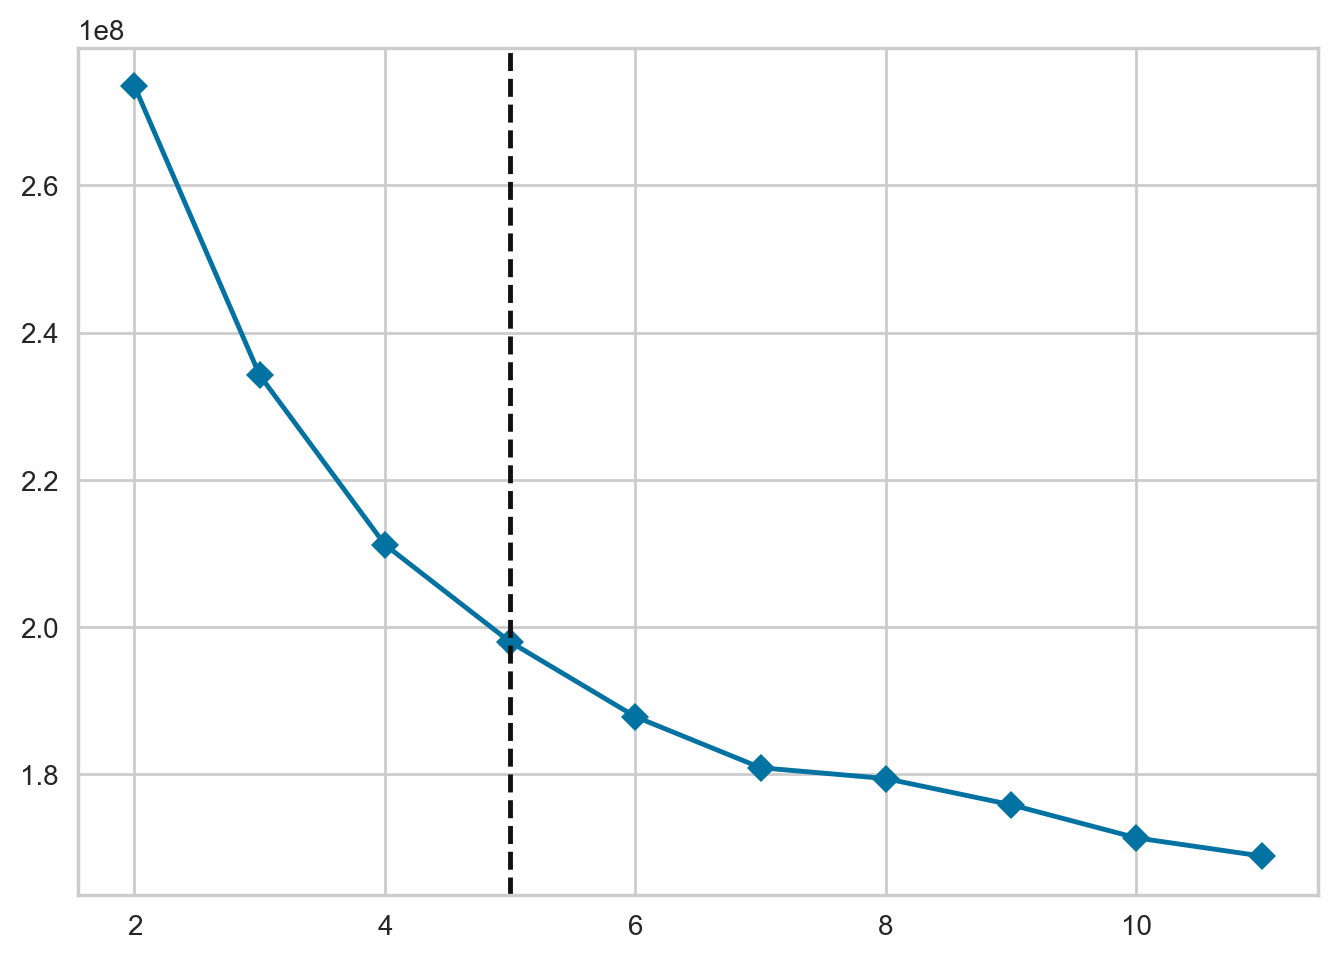

In [ ]:
data_scaled_sample = data_scaled.sample(n=400000) # sample for size of data set

# k-means clusterer

KClusterer = KMeans(n_clusters=3, # initialized with 3 for simplicity
                   verbose=0,
                   random_state=2025) # Name of operator and cluster number

# Elbow visualizer

visualizer = KElbowVisualizer(KClusterer,
                              k=(2,12),
                              locate_elbow=True,
                              timings=False)

visualizer.fit(data_scaled_sample)
visualizer.show

## Chosen: 5 clusters

### Silhouette

In [ ]:
# Silhouette scorer
sil_scores = {}

for i in range(2,12):
    
    sample_scores = []
    
    for _ in range(10):
        current_sample = data_scaled.sample(n=10000, replace=False)
    
        Kmeansclusterer = KMeans(n_clusters=i,
                                verbose=0,
                                random_state=2025,
                                n_init=10)
        cluster_labels = Kmeansclusterer.fit_predict(current_sample.values)
        sil_avg = silhouette_score(current_sample.values, cluster_labels, n_jobs = -1)
        sample_scores.append(sil_avg)
        
    sil_scores[f'{i} clusters'] = np.mean(sample_scores)

print("Silhouette Scores:", sil_scores)
max_values = heapq.nlargest(3, sil_scores.values())
max_keys = [key for key, value in sil_scores.items() if value in max_values]
print("The greatest silhouette scores are from ", max_keys, "with scores of", max_values)

# Chosen: 2 clusters, decreases from there

Silhouette Scores: {'2 clusters': np.float64(0.9526408366952518), '3 clusters': np.float64(0.8954229903638906), '4 clusters': np.float64(0.7932932264361966), '5 clusters': np.float64(0.6741485273558709), '6 clusters': np.float64(0.5818349587098807), '7 clusters': np.float64(0.4754080485328518), '8 clusters': np.float64(0.41279739096972223), '9 clusters': np.float64(0.3876131951723376), '10 clusters': np.float64(0.36993194801621543), '11 clusters': np.float64(0.15155728084027995)}
The greatest silhouette scores are from  ['2 clusters', '3 clusters', '4 clusters'] with scores of [np.float64(0.9526408366952518), np.float64(0.8954229903638906), np.float64(0.7932932264361966)]


### Applying k-means according to best cluster number (data not scaled)

In [12]:
KClusterer = KMeans(n_clusters=5, # put in optimal cluster amount
                   verbose=0,
                   random_state=2025) # Name of operator and cluster number

data_np = data.to_numpy() # not the scaled version
cluster_labels = KClusterer.fit_predict(data_np)
data_cluster_table = data.with_columns(pl.Series("cluster_label", cluster_labels))

cluster_avg = data_cluster_table.group_by("cluster_label").agg([
    pl.col(column).mean().alias(f"{column}_mean") for column in data_cluster_table.columns if column != "cluster_label"
])
print(cluster_avg.sort('cluster_label'))

shape: (5, 976)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ cluster_l ┆ HSBASHHD_ ┆ HSTT001_m ┆ HSTE001_m ┆ … ┆ ECYTCA_18 ┆ ECYNCANCI ┆ ECYNCA_U1 ┆ ECYNCA_1 │
│ abel      ┆ mean      ┆ ean       ┆ ean       ┆   ┆ P_mean    ┆ T_mean    ┆ 8_mean    ┆ 8P_mean  │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ i32       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 0         ┆ 10.035288 ┆ 1.2246e6  ┆ 1.1097e6  ┆ … ┆ 18.30001  ┆ 2.772796  ┆ 0.419928  ┆ 2.352868 │
│ 1         ┆ 1678.1061 ┆ 2.1507e8  ┆ 1.9009e8  ┆ … ┆ 3236.8612 ┆ 115.14693 ┆ 18.895918 ┆ 96.25102 │
│           ┆ 22        ┆           ┆           ┆   ┆ 24        ┆ 9         ┆           ┆          │
│ 2         ┆ 3848.4285 ┆ 5.7884e8  ┆ 4.9623e8  ┆ … ┆ 7616.0428 ┆ 311.58571

## c. Linear dimensionality reductions

### i. Applying PCA

In [20]:
## PCA
nPCA = PCA(n_components=10)
nPCA.fit(np.asarray(data_scaled))
total_variance = np.sum(nPCA.explained_variance_ratio_) * 100
print('The total explained variance of the first %i components is %.3f percent' % (nPCA.n_components_, total_variance))

The total explained variance of the first 10 components is 69.657 percent


### ii. Plot the data of the first two PCs in a scatterplot (scaled data)

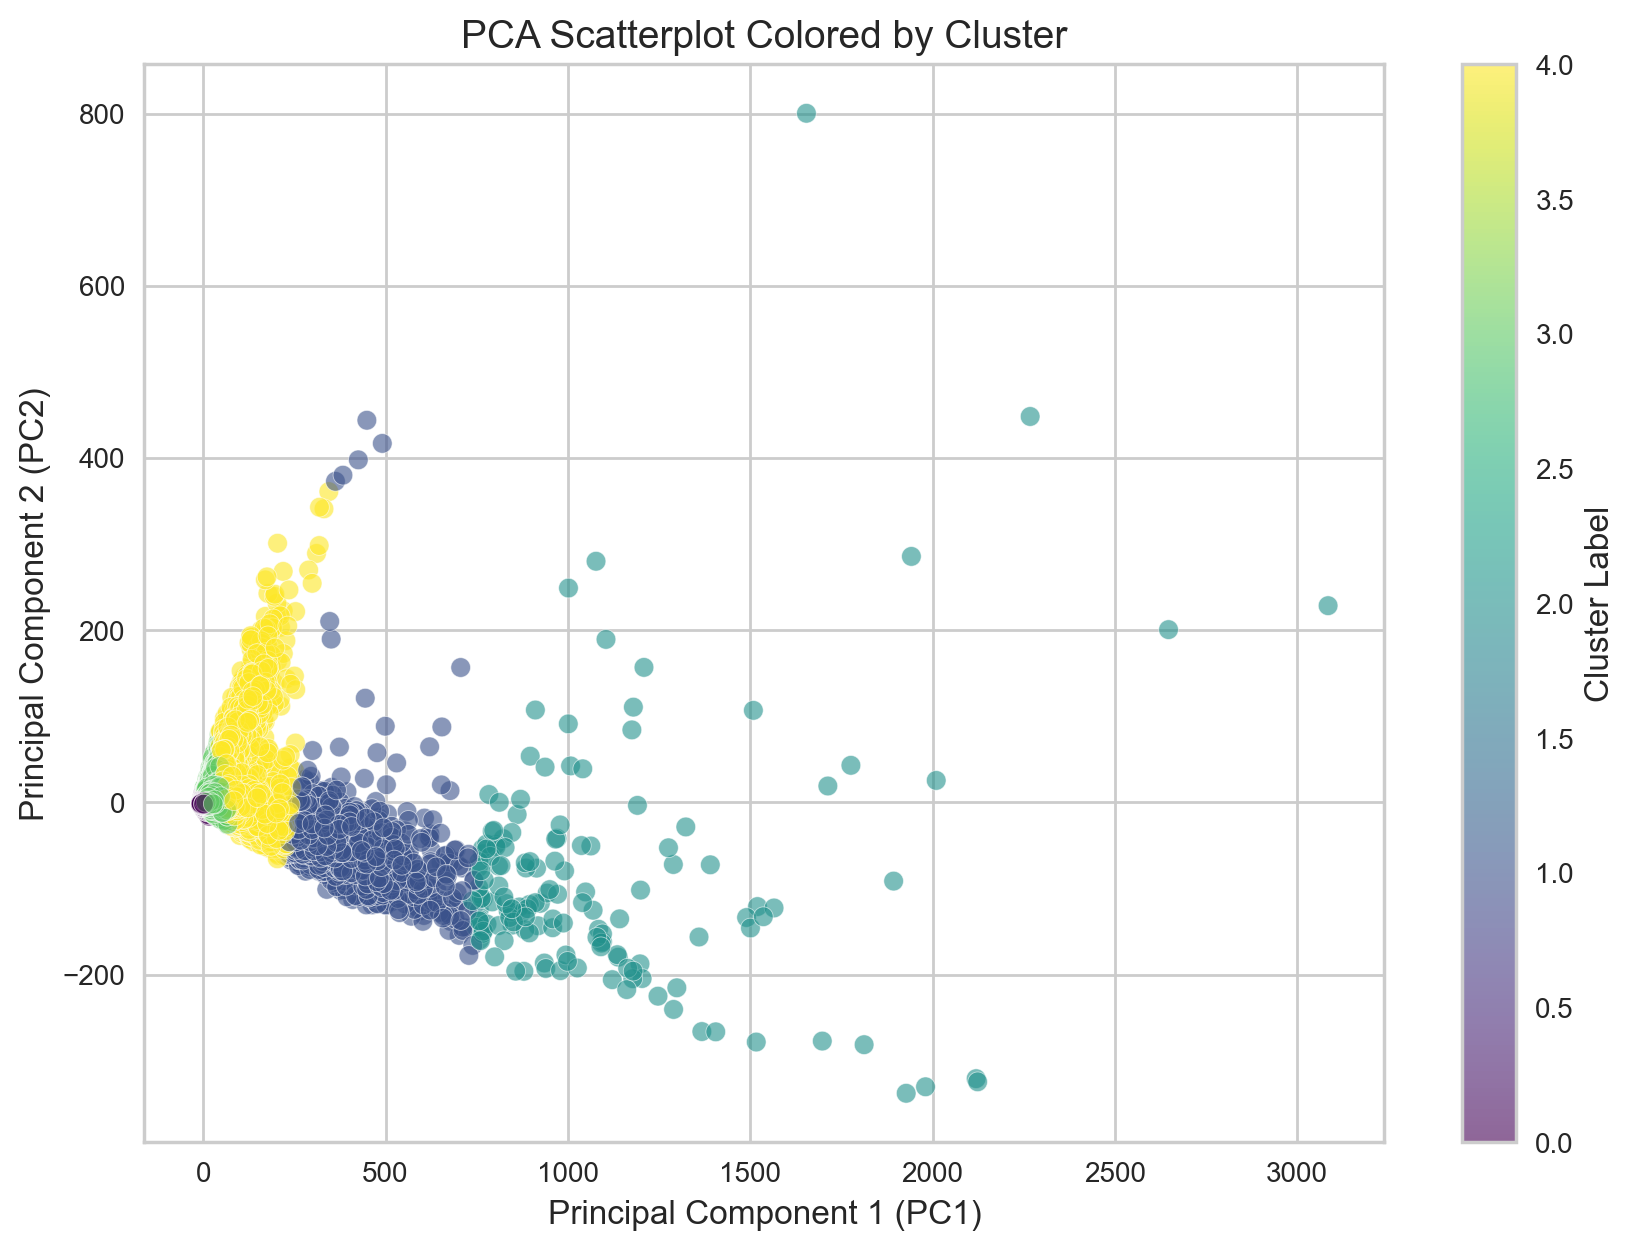

In [22]:
pca_components = nPCA.transform(np.asarray(data_scaled))
pc1 = pca_components[:, 0]  # First principal component
pc2 = pca_components[:, 1]  # Second principal component
pc3 = pca_components[:, 2]  # Third principal component

cluster_labels_scaled = KClusterer.fit_predict(data_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    pc1, 
    pc2, 
    c=cluster_labels_scaled, 
    cmap='viridis',  # You can change to 'plasma', 'rainbow', etc.
    alpha=0.6,       # Slightly transparent points
    edgecolors='w',  # White edges for better visibility
    s=50            # Point size
)

plt.xlabel('Principal Component 1 (PC1)', fontsize=12)
plt.ylabel('Principal Component 2 (PC2)', fontsize=12)
plt.title('PCA Scatterplot Colored by Cluster', fontsize=14)

cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Label', fontsize=12)

plt.show()

### Interpretation

eiosdfgjiopefoaishrgipjgwrig9upafg98 249tu 490u ridgjkl sdfgajkln dg890 wet4t 24wt 

### iii. Calculate average value of first three components, put into table

In [23]:
pca_df = pd.DataFrame({
    'PC1': pc1,
    'PC2': pc2,
    'PC3': pc3,
    'Cluster': cluster_labels_scaled  # From KClusterer.fit_predict(data_scaled)
})

cluster_means = pca_df.groupby('Cluster').mean().reset_index()

def name_cluster(row):
    max_pc = max(['PC1', 'PC2', 'PC3'], key=lambda x: abs(row[x]))
    if max_pc == 'PC1':
        return "High PC1 (Topic A)" if row['PC1'] > 0 else "Low PC1 (Topic B)"
    elif max_pc == 'PC2':
        return "High PC2 (Topic C)" if row['PC2'] > 0 else "Low PC2 (Topic D)"
    else:
        return "High PC3 (Topic E)" if row['PC3'] > 0 else "Low PC3 (Topic F)"

cluster_means['Cluster_Name'] = cluster_means.apply(name_cluster, axis=1)
print(cluster_means[['Cluster', 'Cluster_Name', 'PC1', 'PC2', 'PC3']])

   Cluster        Cluster_Name          PC1        PC2       PC3
0        0   Low PC1 (Topic B)    -3.233421  -1.129091 -0.010857
1        1  High PC1 (Topic A)   391.781606 -53.161465  6.921382
2        2  High PC1 (Topic A)  1089.080026 -87.706520 -7.770757
3        3  High PC1 (Topic A)    14.569282   7.726131 -0.074647
4        4  High PC1 (Topic A)   103.418719  31.064931  1.966968


## d. UMAP

### Choice of parameters

In [36]:
# best parameters to use:

# Define parameter grid
param_grid = {
    'n_neighbors': [5, 15, 30, 50],
    'min_dist': [0.01, 0.1, 0.5],
    'metric': ['euclidean', 'cosine']
}

data_scaled_sample = data_scaled.sample(n=10000, random_state=2025)
cluster_labels_scaled = KClusterer.fit_predict(data_scaled_sample)

best_score = -1
best_params = {}
best_embedding = None

# Grid search (small-scale for demonstration)
for n in param_grid['n_neighbors']:
    for d in param_grid['min_dist']:
        for m in param_grid['metric']:
            reducer = umap.UMAP(n_neighbors=n, min_dist=d, metric=m, random_state=2025, n_jobs=1, verbose=0)
            embedding = reducer.fit_transform(np.asarray(data_scaled_sample))
            score = silhouette_score(embedding, cluster_labels_scaled)
            if score > best_score:
                best_score = score
                best_params = {'n_neighbors': n, 'min_dist': d, 'metric': m}
                best_embedding = embedding

print(f"Best parameters: {best_params}, Silhouette score: {best_score:.3f}")

C:\Users\Andy Yuan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Andy Yuan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\Andy Yuan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or j

Best parameters: {'n_neighbors': 5, 'min_dist': 0.1, 'metric': 'euclidean'}, Silhouette score: -0.066


### Plot UMAP

C:\Users\Andy Yuan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Andy Yuan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\Andy Yuan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or j

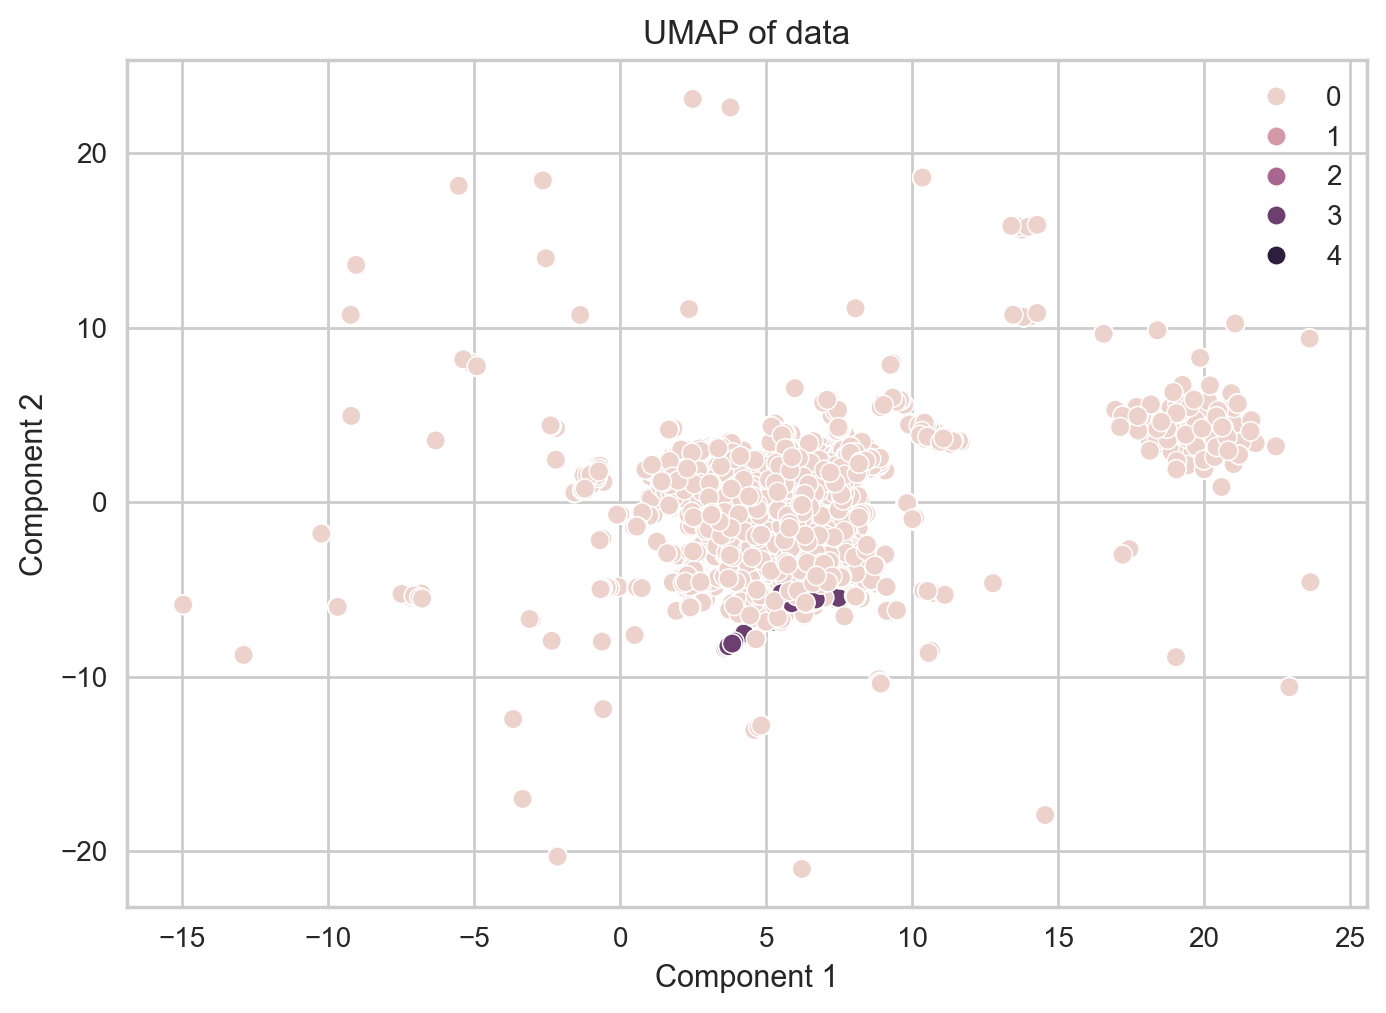

In [37]:
reducer = umap.UMAP(n_neighbors=5,              # Number of neareast neighbours to use. (set to best)
                    n_components=2,              # Number of components. UMAP is robust to larger values
                    metric='euclidean',             # Metric to use. (set to best)
                    n_epochs=1000,               # Iterations. Set to convergence. None implies either 200 or 500.
                    min_dist=0.1,                # Minimum distance embedded points. Smaller makes clumps, larger, sparseness. (set to best)
                    spread=1.0,                  # Scale to combine with min_dist
                    low_memory=False,             # Run slower, but with less memory.
                    n_jobs=-1,                   # Cores to use
                    verbose=0                 # Verbosity
                   )
UMAP_embedding = reducer.fit_transform(data_scaled_sample)

sns.scatterplot(x=UMAP_embedding[:, 0], y=UMAP_embedding[:, 1], hue=cluster_labels_scaled)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("UMAP of data")
plt.show()

# Question 2


In [ ]:
# Dropping columns described in the Discord announcements, need to keep the ones that we will use for the response
columns_to_drop = ["HSHNIAGG", "HSAGDISPIN", "HSAGDISCIN", # incomes
                   "HSEP001", "HSEP002", "HSEP003", "HSEP004", "HSEP005", "HSEP006", "HSEP007", # pension contribution
                   "CODE", "CODE_right", "GEO", "GEO_right"]
ifexisting_cols = [col for col in columns_to_drop if col in data_combined.columns]
datahouseholds = data_combined.drop(ifexisting_cols)
datahouseholds.describe()

In [ ]:
# identify which columns are strings
string_columns = datahouseholds.select(pl.col(pl.Utf8())).columns

# Replace NA with median values of the columns converted to string
for col in string_columns:
    median = (
        datahouseholds[col].replace("NA", None)
        .cast(pl.Float64)
        .median()
    )
    datahouseholds = datahouseholds.with_columns(
        pl.col(col).replace("NA", None)
        .cast(pl.Float64)
        .fill_null(median)
        .alias(col)
    )

In [ ]:
# clean once more
string_columns = datahouseholds.select(pl.col(pl.Utf8())).columns
datahouseholds_cleaned = datahouseholds.with_columns(
    pl.col(string_columns).cast(pl.Float64)
)

In [ ]:
# Clone and scale
# clean data clone
data = datahouseholds_cleaned.clone()
# Scale data
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data.to_pandas()), columns=data.columns)

## a. Regularized elastic net regularized linear regression

In [ ]:
# target variable creation (proportion of income spent on total personal insurance premiums and retirement/pension contributions)
# personal insurance and pension columns
personal_insur_pension_col = ["HSEP001", "HSEP002", "HSEP003", "HSEP004", "HSEP005", "HSEP006", "HSEP007"]
response = sum(personal_insur_pension_col) / data["HSHNIAGG"]